In [ ]:
'''
PPCA v1.0.1

STEP 3: FLOOR CLASSIFICATION

Author: Perez, Joan 

This script begins by ensuring the columns 'height' and 'building:levels' are numeric, converting any non-numeric entries to Null. For residential
buildings, the script then fills missing 'height' values by multiplying floors by 3, assuming an average floor height of 3 meters. Conversely, it 
fills missing building values by dividing 'height' by 3 and rounding the result, again for residential buildings only. It calculates and prints the
number and percentage of rows with Null in both 'height' and 'building. Using the morphometric indicators calculated in STEP 1, the script uses a 
Decision Tree Classifier for evaluating the missing values for the number of floors per building ('FL'). The protocol then splits the data into 
training and testing subsets based on a specified training ratio. The classifier is then trained on the training set and its accuracy is evaluated 
on the test data set. Next, the trained model is used to predict missing 'FL' values (number of floors) in the OSM building data where 'FL' values
are null. The output includes a new variable named 'FL_filled', which contains the original'FL' values for non-null entries and model predictions 
for null entries. Floor-area ('FA') is corrected using the model. Additionally, the script visualizes the decision tree, maps the results, and 
explores how the classifier's accuracy varies with different proportions of training data, plotting accuracy as a function of the training data size.

Requirements
- A specific working environment (see README on the github page of the project https://github.com/perezjoan/PPCA-codes?tab=readme-ov-file)
- Output file PPCA_2-1_{Name}_retained.gpkg ('osm_building_filtered' (Polygon), OSM buildings with light structures filtered out)

Guide to run PPCA STEP 3
- Fill 0.1 box and run the script

Output
- PPCA_3-1_{Name}_IND_FL: Indicators and floors. A geopackage file with a single layer
     * 'osm_buildings_FL_filled' (Polygon), osm buildings with morphometric indicators and missing number of floors filled by Decision Tree 
     Classifier

Acknowledgement
This resource was produced within the emc2 project, which is funded by ANR (France), FFG (Austria), MUR (Italy) and Vinnova (Sweden) under
the Driving Urban Transition Partnership, which has been co-funded by the European Commission.

License: Attribution-ShareAlike 4.0 International - CC-BY-SA-4.0 license
'''

In [1]:
###########################################################################################################################################

# 0.1 : Box to fil with information

# Name of the case study
Name = 'Nice'

# Ratio of data to subset for training the model (Run Appendix A.3 to help selecting the ratio)
Training_ratio = 0.7

###########################################################################################################################################

In [2]:
# 0.2 : libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import libpysal
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# 0.3 Data preparation
# Import OSM buildings
gpkg = f'PPCA_2-1_{Name}_TYPE.gpkg'
building = gpd.read_file(gpkg, layer = 'osm_buildings_res_type')
building = building[building['type_filled'] == 1]

## 1. DATA PREPARATION

# 1.1 FILL & CALCULATE MISSING VALUES FOR HEIGHT & LEVEL

# Ensure height & level columns are numeric
building['height'] = pd.to_numeric(building['height'], errors='coerce')
building['building:levels'] = pd.to_numeric(building['building:levels'], errors='coerce')

# checks if height is Null and if floor is non Null
# If both conditions are met : multiplies the value of floor by 3 and assigns it to height
building['height'] = building.apply(lambda row: row['building:levels'] * 3 if pd.isna(row['height'])
                                     and not pd.isna(row['building:levels']) else row['height'], axis=1)

# checks if the height observation is Null and if the floor is non Null
# If both conditions are met : multiplies the value of floor by 3 and assigns it to height
building['building:levels'] = building.apply(lambda row: round(row['height'] / 3) if pd.isna(row['building:levels'])
                                             and not pd.isna(row['height']) else row['building:levels'], axis=1)

# Calculate the number and percentage of rows with Null for both 'height' and 'building:levels'
num_na = building[['height', 'building:levels']].isna().all(axis=1).sum()
percent_na = (num_na / len(building)) * 100

# Print the number and percentage of rows with NA for both columns
print(f'{Name} : Number of remaining values with Null for height/floors: {num_na} ({percent_na:.2f}%)')

# 1.2 ADD FLOOR-AREA RATIO TO LIST OF INDICATORS

# Rename number of floors
building.rename(columns={'building:levels': 'FL'}, inplace=True)

# Floor area
building['FA'] = building['FL'] * building['A']

## 2. DECISION TREE CLASSIFIER TO EVALUATE THE MISSING NUMBER OF FLOORS

# 2.1 SUBSET DATA INTO TRAIN AND TEST DATA

# List of columns to keep
columns_to_keep = ['A', 'P', 'E', 'C', 'FA', 'ECA', 'EA', 'SW', 'FL']

# Subset the DataFrame
building_filtered = building[columns_to_keep]

# Create two subsets: one with non-null 'FL' and one with null 'FL'
building_non_null = building_filtered[building_filtered['FL'].notnull()]
building_null = building_filtered[building_filtered['FL'].isnull()]

# Set a random seed for reproducibility
np.random.seed(45)

# Create a boolean mask for selecting the data for training
mask = np.random.rand(len(building_non_null)) < Training_ratio

# Split the data into training and testing sets
data_train = building_non_null[mask]
data_test = building_non_null[~mask]

# Display the shapes of the resulting datasets
print(f"Training data shape - (observations, columns): {data_train.shape}")
print(f"Testing data shape - (observations, columns): {data_test.shape}")

# 2.2 CALCULATE DECISION TREE CLASSIFIER & PRINT ACCURACY

# Initialize the Decision Tree Classifier
np.random.seed(45)
clf = DecisionTreeClassifier()

# Explicitly cast FL to float64 before rounding and converting to categorical
data_train = data_train.copy()
data_test = data_test.copy()
data_train['FL'] = data_train['FL'].astype(np.float64).round().astype('int32').astype('category')
data_test['FL'] = data_test['FL'].astype(np.float64).round().astype('int32').astype('category')

# Separate the target variable and features for the training set
X_train = data_train.drop(columns=['FL'])
y_train = data_train['FL']

# Train the classifier
clf.fit(X_train, y_train)

# Separate the features and target variable for the test set
X_test = data_test.drop(columns=['FL'])
y_test = data_test['FL']

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")

# Apply the model to building_null
# Ensure that we are using the same features as those used during training
X_null = building_null.drop(columns=['FL'])

# Make sure there are no additional columns
X_null = X_null[X_train.columns]

# Predict the types for building_null
building_null = building_null.copy()
building_null['FL'] = clf.predict(X_null)

# 2.3 APPLY THE TREE TO THE NULL VALUES
X_null = building_filtered.drop(columns=['FL'])

# Predict the types for building_null
building_filtered = building_filtered.copy()  # Ensure we are working on a copy
building_filtered.loc[:, 'FL_pred'] = clf.predict(X_null)

# Keep only one column from building_filtered
type_pred = building_filtered[['FL_pred']]

# Concatenate along columns
building_final = pd.concat([building.reset_index(drop=True), type_pred.reset_index(drop=True)], axis=1)

# Create the 'type_filled' column which take the non null values of building type, otherwise fill the null values with the model predictions
building_final['FL_filled'] = np.where(building_final['FL'].notna(), 
                                       building_final['FL'], 
                                       building_final['FL_pred'])

# Correction of FA (floor-area) using 'FL_filled'
building_final['FA'] = building_final['FL_filled'] * building_final['A']

print(f'Number of observations filled by DTS model: {num_na}')

Nice : Number of remaining values with Null for height/floors: 45220 (59.80%)
Training data shape - (observations, columns): (21239, 9)
Testing data shape - (observations, columns): (9160, 9)
Accuracy on test data: 0.97
Number of observations filled by DTS model: 45220


In [3]:
###########################################################################################################################################

## APPENDICES

# A1. Save Outputs
gpkg = f'PPCA_3-1_{Name}_IND_FL.gpkg'
building_final.to_file(gpkg, layer='osm_buildings_FL_filled', driver="GPKG")

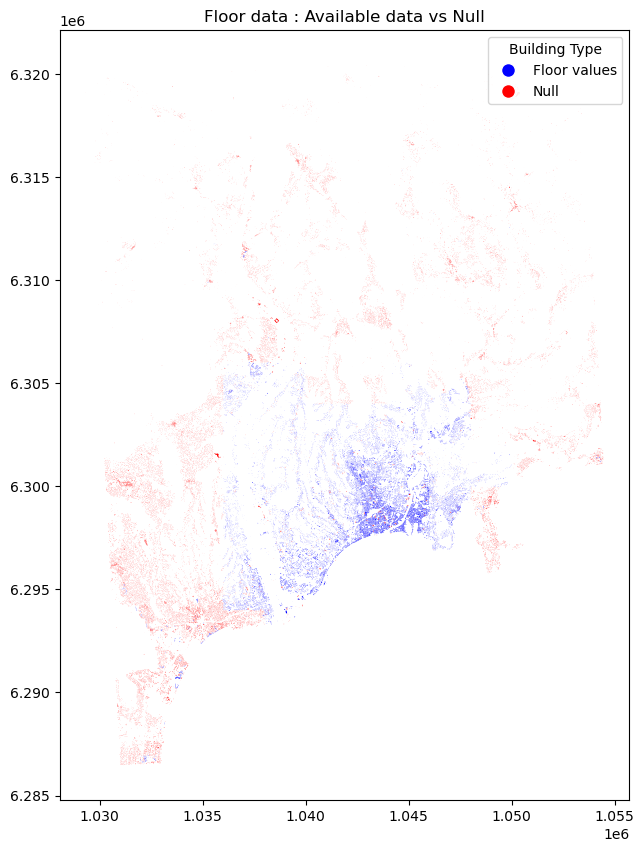

In [4]:
# A2. Map of Floor

# Define custom colors
colors = ['blue', 'red']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
building[building['FL'].notna()].plot(ax=ax, color=colors[0], edgecolor=None, label='With FL')
building[building['FL'].isna()].plot(ax=ax, color=colors[1], edgecolor=None, label='No FL')

# Add custom legend
legend_labels = ['Floor values', 'Null']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(colors))]
ax.legend(handles, legend_labels, title='Building Type')

# Set the title
ax.set_title('Floor data : Available data vs Null')

# Display the plot
plt.show()

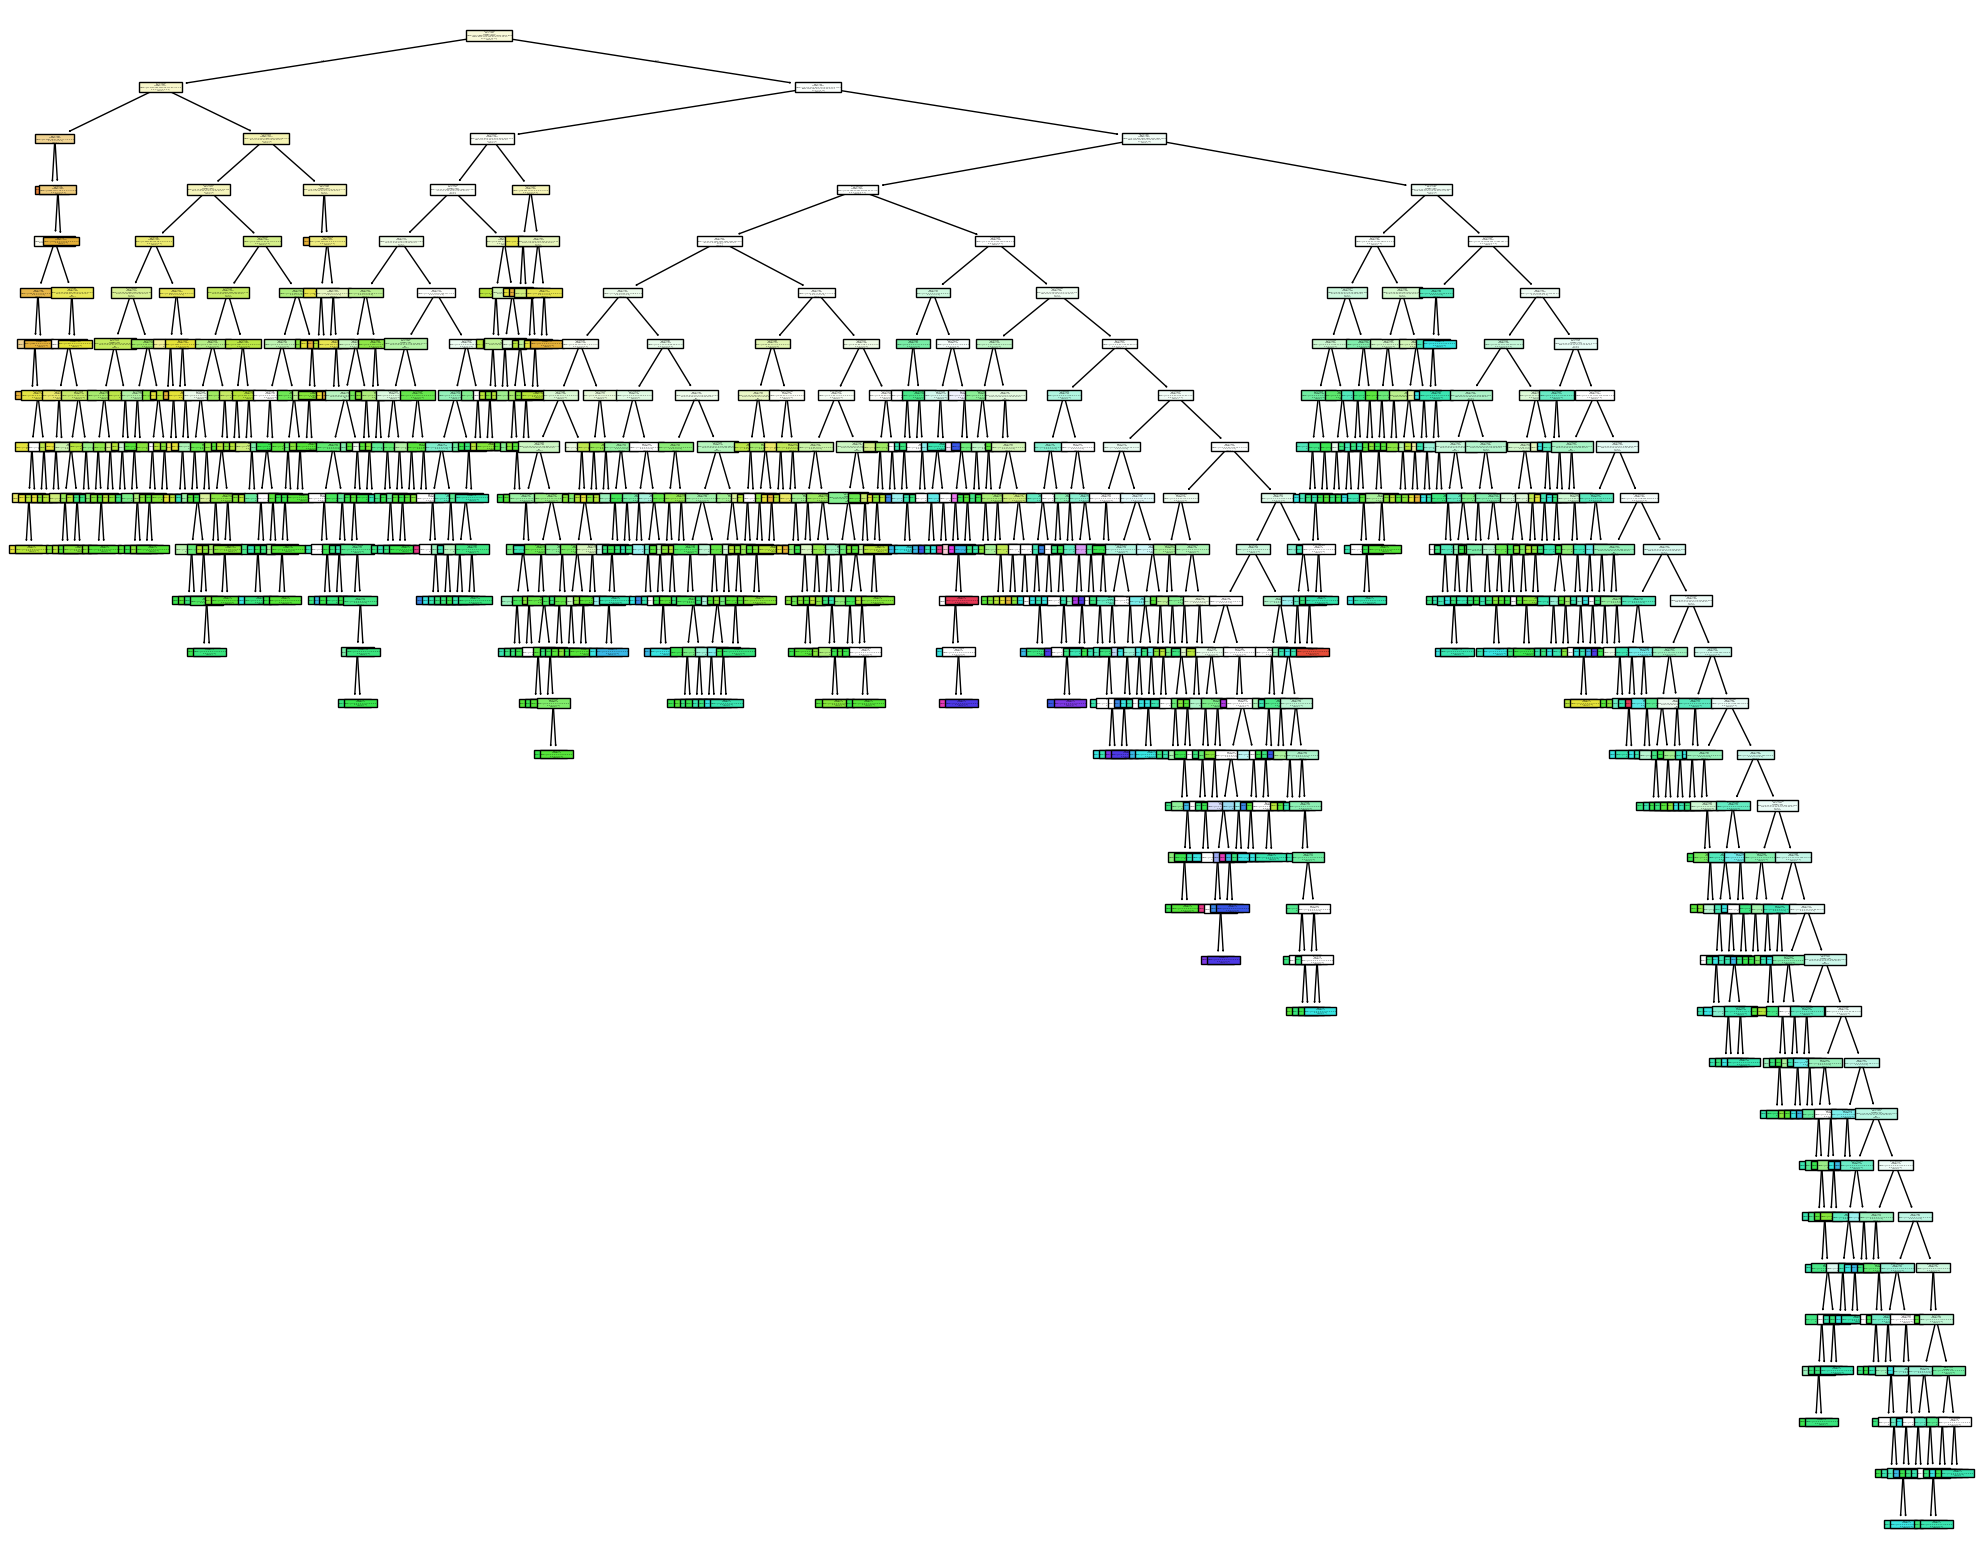

In [5]:
# A3. Tree Vizualization
unique_classes = list(map(str, sorted(set(y_train))))

# Visualize the decision tree
def visualize_tree(clf, feature_names, class_names):
    plt.figure(figsize=(25, 20))
    tree.plot_tree(clf, 
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)
    plt.show()

# Call the function with the correct class names
visualize_tree(clf, X_train.columns, unique_classes)

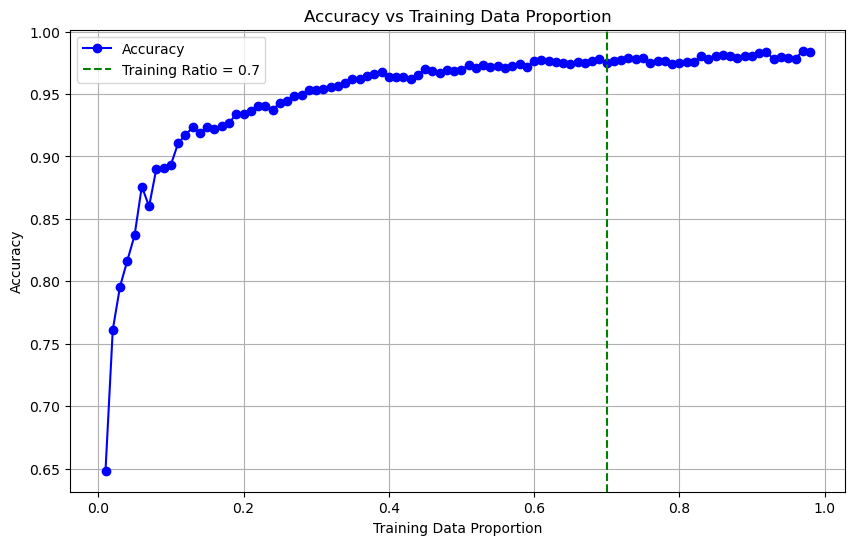

In [6]:
# A4. Compute Accuracy based on trainning data size

# Define the proportions for training data
train_proportions = np.arange(0.01, 0.99, 0.01)

# Lists to store proportions and accuracies
proportions_list = []
accuracies_list = []

# Loop over each training proportion
for proportion in train_proportions:
    # Set a random seed for reproducibility
    np.random.seed(45)

    # Create a boolean mask for selecting the proportion of the data for training
    mask = np.random.rand(len(building_non_null)) < proportion

    # Split the data into training and testing sets
    data_train = building_non_null[mask]
    data_test = building_non_null[~mask]

    # Ensure the FL column is treated as categorical
    data_train = data_train.copy()
    data_test = data_test.copy()
    
    data_train['FL'] = data_train['FL'].astype(np.float64).round().astype(np.int32)
    data_train['FL'] = data_train['FL'].astype('category')

    data_test['FL'] = data_test['FL'].astype(np.float64).round().astype(np.int32)
    data_test['FL'] = data_test['FL'].astype('category')

    # Initialize the Decision Tree Classifier
    clf = DecisionTreeClassifier()

    # Separate the target variable and features for the training set
    X_train = data_train.drop(columns=['FL'])
    y_train = data_train['FL']

    # Train the classifier
    clf.fit(X_train, y_train)

    # Separate the features and target variable for the test set
    X_test = data_test.drop(columns=['FL'])
    y_test = data_test['FL']

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store the proportion and accuracy
    proportions_list.append(proportion)
    accuracies_list.append(accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(proportions_list, accuracies_list, marker='o', color='blue', label='Accuracy')

# Adding a vertical line at Training_ratio
plt.axvline(x=Training_ratio, color='green', linestyle='--', label=f'Training Ratio = {Training_ratio}')
plt.title('Accuracy vs Training Data Proportion')
plt.xlabel('Training Data Proportion')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

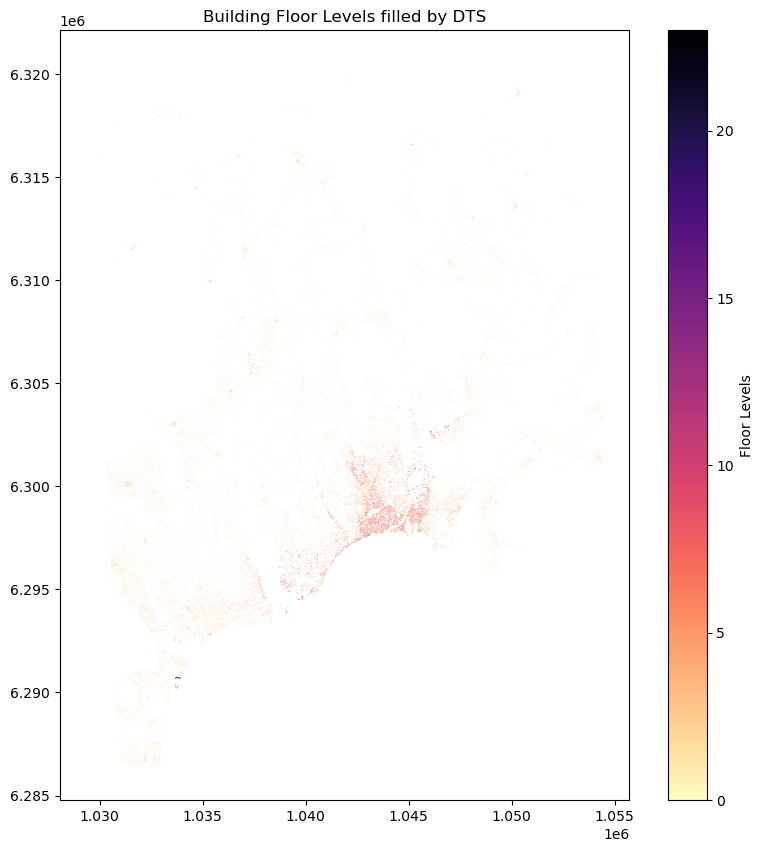

In [7]:
# A5. Map of floor filled by DTS

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.colormaps.get_cmap('magma_r')  # Use the reversed palette
norm = mcolors.Normalize(vmin=building_final['FL_filled'].min(), vmax=building_final['FL_filled'].max())

# Plot the buildings
building_final.plot(column='FL_filled', ax=ax, legend=False, cmap=cmap, norm=norm, edgecolor=None)

# Set the title
ax.set_title('Building Floor Levels filled by DTS')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Floor Levels')

# Display the plot
plt.show()